# Project: Interconnect

## Introduction.

In the telecommunications industry, customer churn is a challenge that affects the stability and growth of businesses. Interconnect, a telecommunications operator, seeks to reduce churn by identifying at-risk customers early. To this end, the marketing team has collected data on customers and their contracts to develop a machine learning model that predicts the likelihood of churn.


## Goal.

Develop a machine learning model capable of predicting customer churn with high accuracy, using the AUC-ROC metric as the main performance indicator. This will allow Interconnect to implement targeted retention strategies, such as promotions and personalized plans, to reduce customer churn.

## Development plan

**1. Data Exploration and Preprocessing:** <br><br>

We will load and analyze the available datasets to understand their structure and detect potential issues. We will identify null values, duplicates, and inconsistencies that may affect the analysis. We will then evaluate how the datasets will be handled and merge them into a single table based on customerID. We will verify the data types and perform the necessary transformations to ensure their correct interpretation by the models. In addition, we will manage missing and outlier values, applying appropriate strategies to avoid bias in the modeling. <br>

**2. Exploratory Analysis:** <br><br>

We will explore the relationship between variables and the churn rate to understand which factors influence customer retention. We will identify relevant patterns and correlations that can provide useful information for prediction. We will also analyze the distribution of the target variable, checking for class balance and potential biases in the data.<br>

**3. Model Training and Evaluation:**<br><br>

We will select and train multiple classification models, including logistic regression, decision trees, and boosting-based models. We will compare the models' performance using AUC-ROC and accuracy as key metrics. Additionally, we will optimize the hyperparameters of the most promising model to improve its performance and achieve the best possible predictive capability.<br>

**4. Results and Conclusions:**<br><br>

We will analyze the selected model and evaluate its impact on churn prediction, ensuring it meets the project objectives. We will present recommendations based on the findings and discuss possible improvements. Finally, we will propose strategies for implementing the model within the company, enabling Interconnect to implement effective measures to retain its customers.<br>

## Development.

### 1. EDA and pre processing.

#### Library import.

In [152]:

import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier


#### Load data

In [153]:
try:
    contract_df = pd.read_csv("/Users/pauli/Documents/final_provider/contract.csv")
    internet_df = pd.read_csv("/Users/pauli/Documents/final_provider/internet.csv")
    personal_df = pd.read_csv("/Users/pauli/Documents/final_provider/personal.csv")
    phone_df = pd.read_csv("/Users/pauli/Documents/final_provider/phone.csv")

except FileNotFoundError:
    contract_df = pd.read_csv("/datasets/final_provider/contract.csv")
    internet_df = pd.read_csv("/datasets/final_provider/internet.csv")
    personal_df = pd.read_csv("/datasets/final_provider/personal.csv")
    phone_df = pd.read_csv("/datasets/final_provider/phone.csv")


#### Preprocessing data

##### Contract df

In [154]:


contract_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


The first thing we notice is that we need to change the column names to snake case and change the data type for the columns containing date information to datetime format. The rest of the data types appear to be correct. <br>
Something important is that the end_date column, which will be our target column, contains the string "No" to indicate the plans that are still active. Therefore, we'll create a new Boolean column to indicate the plans that have already ended and those that have not. We'll leave the end_date column as datetime so we can perform calculations if necessary.
Finally, we'll change the column type from total charges to numeric.

In [ ]:
# Rename columns

contract_df.columns = ['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges']

# Convert begin_date to datetime
contract_df['begin_date'] = pd.to_datetime(contract_df['begin_date'])

# Convert total_charges to numeric data.

contract_df["total_charges"] = pd.to_numeric(contract_df["total_charges"], errors="coerce").fillna(0.0)




In [ ]:
# Create a new column indicating whether the client is still active
contract_df['active_customer'] = (contract_df['end_date'] == 'No').astype(int)

# Convert end_date to datetime, keeping 'No' as is
contract_df['end_date'] = pd.to_datetime(contract_df['end_date'].replace('No', None))


print(contract_df.info())
print(contract_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   active_customer    7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 495.3+ KB
None
  customer_id begin_date   end_date            type paperless_billing  \
0  7590-VHVEG 2020-01-01        NaT  Month-to-month               Yes   
1  5575-GNVDE 2017-04-01        NaT        One year    

In [ ]:
#Check for null or duplicate values

print (contract_df.isnull().sum())
print (contract_df.duplicated().sum())

customer_id             0
begin_date              0
end_date             5174
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
active_customer         0
dtype: int64
0


It is observed that there are no duplicate values, and null values ​​are only found in end_date as expected due to the change made above.

##### Internet DF

In [158]:
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


The data types are correct, the only suggested change is to change the column names to snake type.

In [ ]:
internet_df.columns = ['customer_id', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

#Check name change

internet_df.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [ ]:
#Check for null or duplicate values

print (internet_df.isnull().sum())
print (internet_df.duplicated().sum())

customer_id          0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
dtype: int64
0


There are no null or duplicate values ​​in this dataset.

##### Personal df

In [161]:
personal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


The data types are correct, the only suggested change is to change the column names to snake type.

In [ ]:
# Rename
personal_df.columns = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents']

# Check name change

personal_df.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [ ]:
#Check for null or duplicate values

print (personal_df.isnull().sum())
print (personal_df.duplicated().sum())

customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64
0


There are no null or duplicate values ​​in this dataset.

##### Phone df

In [164]:
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


The data types are correct, the only suggested change is to change the column names to snake type. 

In [ ]:
# Rename
phone_df.columns = ['customer_id', 'multiple_lines']

# Check name change

phone_df.head()


,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [166]:
#Comprobar si hay valores nulos o duplicados

print (phone_df.isnull().sum())
print (phone_df.duplicated().sum())

customer_id       0
multiple_lines    0
dtype: int64
0


There are no null or duplicate values ​​in this dataset.

#### Merge the Datasets

In [167]:

merged_df = contract_df.merge(internet_df, on="customer_id", how="left")
merged_df = merged_df.merge(personal_df, on="customer_id", how="left")
merged_df = merged_df.merge(phone_df, on="customer_id", how="left")


merged_df.head()


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,active_customer,internet_service,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,1,DSL,...,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,1,DSL,...,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,0,DSL,...,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,1,DSL,...,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,0,Fiber optic,...,No,No,No,No,No,Female,0,No,No,No


Let's check the number of null values ​​in each column of merged_df to see how complete the dataset is after the merge.

In [168]:
merged_df.isnull().sum()


customer_id             0
begin_date              0
end_date             5174
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
active_customer         0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
gender                  0
senior_citizen          0
partner                 0
dependents              0
multiple_lines        682
dtype: int64

It appears that the columns with null values ​​come from the internet_df dataset. Since this dataset contains information about internet services, the null values ​​most likely correspond to customers who don't have internet service. Therefore, we'll replace these NaN values ​​with 'No'. We'll do the same with the NaN values ​​in multiple_lines.

In [169]:
internet_cols = ["internet_service", "online_security", "online_backup", "device_protection", "tech_support", "streaming_tv", "streaming_movies"
]

merged_df[internet_cols] = merged_df[internet_cols].fillna("No")

merged_df["multiple_lines"] = merged_df["multiple_lines"].fillna("No")

In [170]:
#Comprobar que ya no hay valores nulos

merged_df.isnull().sum()

customer_id             0
begin_date              0
end_date             5174
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
active_customer         0
internet_service        0
online_security         0
online_backup           0
device_protection       0
tech_support            0
streaming_tv            0
streaming_movies        0
gender                  0
senior_citizen          0
partner                 0
dependents              0
multiple_lines          0
dtype: int64

In [171]:
merged_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   active_customer    7043 non-null   int64         
 9   internet_service   7043 non-null   object        
 10  online_security    7043 non-null   object        
 11  online_backup      7043 non-null   object        
 12  device_protection  7043 non-null   object        
 13  tech_support       7043 non-null   object        
 14  streamin

We cleaned and unified the data, ensuring consistency. We converted column names to snake_case, adjusted data types, and handled null values, replacing those for internet services and phone lines with "No." We also created the active_customer variable to identify active customers. We did not change categorical or binary variables to Boolean, as they will be coded later.

The final dataset has 7,043 records and 21 columns, ready for exploratory analysis.

### 2. EDA.

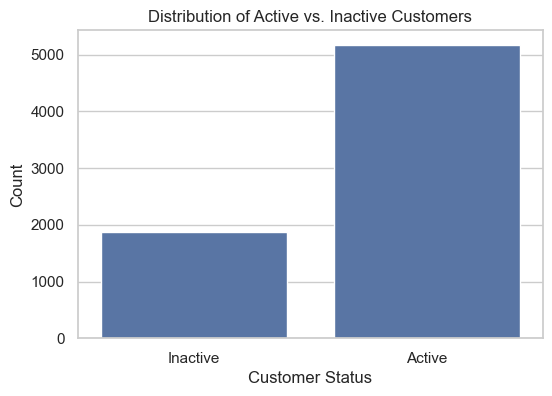

In [ ]:
sns.set_style("whitegrid")

# 1. Distribution of active vs. inactive customers
plt.figure(figsize=(6, 4))
sns.countplot(x="active_customer", data=merged_df)
plt.xticks([0, 1], ["Inactive", "Active"])
plt.xlabel("Customer Status")
plt.ylabel("Count")
plt.title("Distribution of Active vs. Inactive Customers")
plt.show()

The graph shows that there are significantly more active customers than inactive ones, indicating a class imbalance in the target variable. This can affect model performance, so we will later consider techniques such as oversampling, undersampling, or adjusting class weights to improve churn prediction.

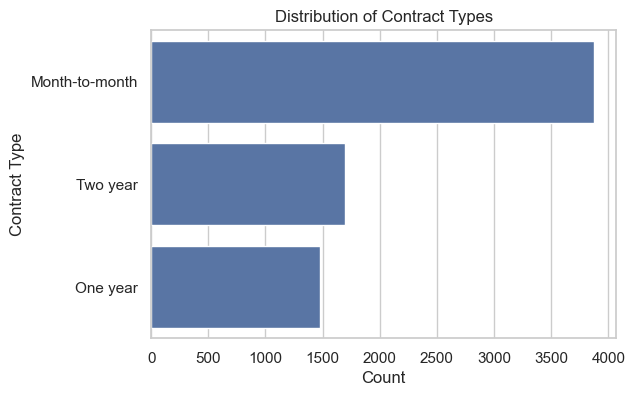

In [ ]:
# Contract type distribution
plt.figure(figsize=(6, 4))
sns.countplot(y="type", data=merged_df, order=merged_df["type"].value_counts().index)
plt.xlabel("Count")
plt.ylabel("Contract Type")
plt.title("Distribution of Contract Types")
plt.show()

This chart shows that most customers have monthly contracts, while one- and two-year contracts are less common.
This could indicate that customers with monthly contracts have more flexibility to cancel service, which could be related to a higher churn rate. To confirm this, let's analyze the proportion of inactive customers with each contract type.

/var/folders/cq/bs731p7n52x64481gqr1xjvm0000gn/T/ipykernel_71548/556824438.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/cq/bs731p7n52x64481gqr1xjvm0000gn/T/ipykernel_71548/556824438.py:8: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


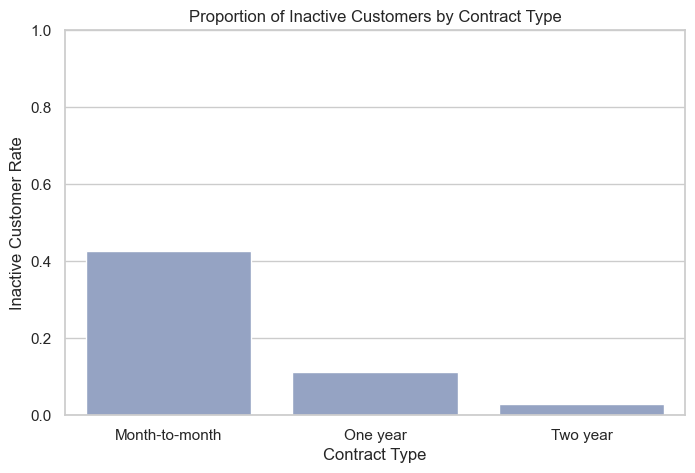

In [ ]:
contract_status_counts = contract_df.groupby(["type", "active_customer"]).size().unstack()

# Calculate the percentage of inactive customers by contract type
contract_status_counts["Inactive_Rate"] = contract_status_counts[0] / contract_status_counts.sum(axis=1)


plt.figure(figsize=(8, 5))
sns.barplot(
    x=contract_status_counts.index,
    y=contract_status_counts["Inactive_Rate"],
    palette=["#8da0cb"]
)
plt.ylabel("Inactive Customer Rate")
plt.xlabel("Contract Type")
plt.title("Proportion of Inactive Customers by Contract Type")
plt.ylim(0, 1)
plt.show()


The graph confirms what was expected: the cancellation rate is much higher for customers with monthly contracts compared to those with one- or two-year contracts.

/var/folders/cq/bs731p7n52x64481gqr1xjvm0000gn/T/ipykernel_71548/1911180214.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=contract_df["active_customer"], y=contract_df["monthly_charges"], palette=["#e41a1c", "#377eb8"])
/var/folders/cq/bs731p7n52x64481gqr1xjvm0000gn/T/ipykernel_71548/1911180214.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=contract_df["active_customer"], y=contract_df["total_charges"], palette=["#e41a1c", "#377eb8"])


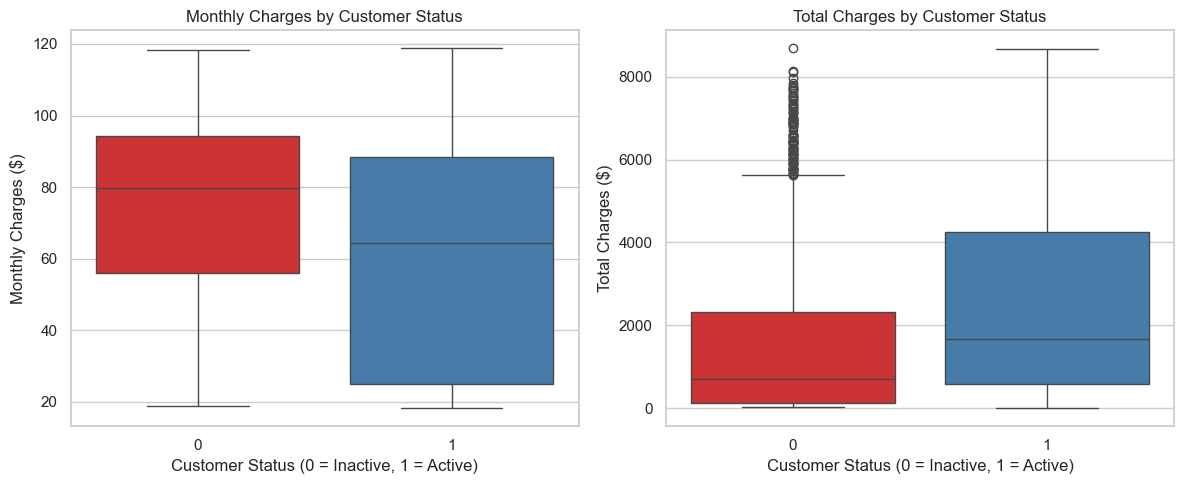

In [ ]:
#Compare monthly and total charges between active and inactive customers

plt.figure(figsize=(12, 5))

# Monthly charges
plt.subplot(1, 2, 1)
sns.boxplot(x=contract_df["active_customer"], y=contract_df["monthly_charges"], palette=["#e41a1c", "#377eb8"])
plt.xlabel("Customer Status (0 = Inactive, 1 = Active)")
plt.ylabel("Monthly Charges ($)")
plt.title("Monthly Charges by Customer Status")

# Total charges
plt.subplot(1, 2, 2)
sns.boxplot(x=contract_df["active_customer"], y=contract_df["total_charges"], palette=["#e41a1c", "#377eb8"])
plt.xlabel("Customer Status (0 = Inactive, 1 = Active)")
plt.ylabel("Total Charges ($)")
plt.title("Total Charges by Customer Status")

plt.tight_layout()
plt.show()


**Monthly Fees:** Inactive customers (red) tend to pay higher monthly fees compared to active customers (blue). This suggests that customers with higher fees may cancel more frequently. <br>
**Total Fees:** Inactive customers have paid less overall, indicating that they cancel earlier. There are a large number of outliers among active customers, suggesting that some have been with the company for a long time and have accumulated high payments. This confirms the hypothesis that cancellations occur more frequently with short contracts or new customers.

Now, to streamline the model a bit, we'll eliminate columns that don't affect the prediction, starting with customer_id, since it's just an identifier, and total_charges, which is highly correlated with monthly_charges. We also eliminate the end_date, since it's only known for customers who have already left; it's not useful for predictions. We also have the column that indicates whether the customer is active or not.

In [176]:
merged_df = merged_df.drop(columns=["customer_id", "total_charges", "end_date"])


Additionally, we're going to remove the begin date column and add one that calculates how many months the client has been around, to avoid formatting issues when arranging the data for the model.

In [ ]:

# Reference date
reference_date = pd.to_datetime("2020-02-01")

# Calculate customer tenure in full months
merged_df["months_active"] = ((reference_date - merged_df["begin_date"]).dt.days // 30).astype(int)

# Delete begin date
merged_df = merged_df.drop(columns=["begin_date"])



In [178]:
merged_df.head()


,type,paperless_billing,payment_method,monthly_charges,active_customer,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,months_active
0,Month-to-month,Yes,Electronic check,29.85,1,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,No,1
1,One year,No,Mailed check,56.95,1,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No,34
2,Month-to-month,Yes,Mailed check,53.85,0,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No,4
3,One year,No,Bank transfer (automatic),42.30,1,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,No,45
4,Month-to-month,Yes,Electronic check,70.70,0,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No,5


In the EDA, we identified that most customers are still active, and that there is a significant imbalance between classes. We found that monthly contracts are associated with a higher churn rate. Furthermore, customers who cancel tend to have higher monthly charges but lower total spending, suggesting early cancellations.

We also analyzed temporal behavior and created a new variable, months_active, to represent customer tenure in months. Finally, we observed that numerical variables have moderate correlations with churn, indicating that categorical variables will play a key role in predictive models.

#### Prepare data for training and correct class imbalance with SMOTE.

In [179]:

X = merged_df.drop(columns=['active_customer'])
y = merged_df['active_customer']

# OHE
X = pd.get_dummies(X, drop_first=True)


X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y)

# SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)



/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


### 3. Model training and evaluation.

In [ ]:
#Sanity Test

dummy = DummyClassifier(strategy="most_frequent", random_state=15)
dummy.fit(X_train, y_train)

# Predict
y_pred_dummy = dummy.predict(X_test)
y_proba_dummy = dummy.predict_proba(X_test)[:, 1]

# Evaluation
print("Dummy Classifier Report (Most Frequent Strategy):")
print(classification_report(y_test, y_pred_dummy))

roc_auc = roc_auc_score(y_test, y_proba_dummy)
print(f"ROC AUC Score: {roc_auc:.4f}")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dummy))


Dummy Classifier Report (Most Frequent Strategy):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       374
           1       0.73      1.00      0.85      1035

    accuracy                           0.73      1409
   macro avg       0.37      0.50      0.42      1409
weighted avg       0.54      0.73      0.62      1409

ROC AUC Score: 0.5000
Confusion Matrix:
[[   0  374]
 [   0 1035]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The model didn't predict any of them correctly. Although the accuracy is 73%, this is misleading: it only reflects that most customers are active. The model isn't learning anything useful.

This result is expected and desired as a baseline. Any model we test from now on must exceed these metrics.

In [181]:
# Logistic Regression

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

logreg = LogisticRegression(random_state=15, max_iter=1000)
logreg.fit(X_train_scaled, y_train_resampled)

y_pred_logreg = logreg.predict(X_test_scaled)
y_proba_logreg = logreg.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logreg))

roc_auc = roc_auc_score(y_test, y_proba_logreg)
print(f"ROC AUC Score: {roc_auc:.4f}")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logreg))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.65      0.57       374
           1       0.86      0.77      0.81      1035

    accuracy                           0.74      1409
   macro avg       0.69      0.71      0.69      1409
weighted avg       0.77      0.74      0.75      1409

ROC AUC Score: 0.8001
Confusion Matrix:
[[244 130]
 [234 801]]


The model correctly predicted 244 out of 374 churns, and correctly predicted 801 active customers, although it was mistaken for 234. It also achieved an overall accuracy of 74% and an ROC AUC of 0.80, indicating a good ability to distinguish between churning and remaining active customers.

In [ ]:
#RandomForestClassifier (default parameters)

rf = RandomForestClassifier(random_state=15)
rf.fit(X_train_resampled, y_train_resampled)


y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]


print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

roc_auc = roc_auc_score(y_test, y_proba_rf)
print(f"ROC AUC Score: {roc_auc:.4f}")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.62      0.60       374
           1       0.86      0.83      0.85      1035

    accuracy                           0.78      1409
   macro avg       0.72      0.73      0.72      1409
weighted avg       0.78      0.78      0.78      1409

ROC AUC Score: 0.8178
Confusion Matrix:
[[231 143]
 [171 864]]


The model achieved an accuracy of 78%, which represents an improvement over the logistic regression model. It achieved an ROC AUC score of 0.8178, slightly exceeding the value obtained with logistic regression and suggesting a better ability to distinguish between customers who cancel and those who do not.

In [183]:
#Random Forrest con Hiperparámetros 


rf_base = RandomForestClassifier(random_state=15)


param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']}


grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1)


grid_search.fit(X_train_resampled, y_train_resampled)


best_rf = grid_search.best_estimator_


y_pred_best = best_rf.predict(X_test)
y_proba_best = best_rf.predict_proba(X_test)[:, 1]

print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best))

roc_auc = roc_auc_score(y_test, y_proba_best)
print(f"ROC AUC Score: {roc_auc:.4f}")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.61      0.59       374
           1       0.86      0.84      0.85      1035

    accuracy                           0.78      1409
   macro avg       0.72      0.73      0.72      1409
weighted avg       0.78      0.78      0.78      1409

ROC AUC Score: 0.8164
Confusion Matrix:
[[230 144]
 [170 865]]


The model with tuned hyperparameters doesn't improve significantly compared to the baseline. The F1, ROC AUC, and accuracy are the same, so it's not worthwhile.

In [184]:
#LightGBM 


lgbm = lgb.LGBMClassifier(random_state=15)
lgbm.fit(X_train_resampled, y_train_resampled)


y_pred_lgb = lgbm.predict(X_test)
y_proba_lgb = lgbm.predict_proba(X_test)[:, 1]


print("LightGBM Classification Report:")
print(classification_report(y_test, y_pred_lgb))

roc_auc = roc_auc_score(y_test, y_proba_lgb)
print(f"ROC AUC Score: {roc_auc:.4f}")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lgb))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4139, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 371
[LightGBM] [Info] Number of data points in the train set: 8278, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.63      0.60       374
           1       0.86      0.82      0.84      1035

    accuracy                           0.77      1409
   macro avg       0.71      0.73      0.72      1409
weighted avg       0.78      0.77      0.78      1409

ROC AUC Score: 0.8250
Confusion Matrix:
[[237 137]
 [185 850]]

Although the churn F1 score is equal to that of Random Forest, the ROC AUC is the highest to date (0.82), indicating better overall discrimination between classes.
For class 0 (customers who canceled), it achieved a precision of 0.56 and a recall of 0.63, meaning it correctly detected 63% of actual churns.
In class 1 (active customers), the model maintained high performance with a precision of 0.86, a recall of 0.82, and an F1 score of 0.84, demonstrating good balance across both classes.

In [185]:
#XG Boost

xgb = XGBClassifier(random_state=15, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_resampled, y_train_resampled)


y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

roc_auc = roc_auc_score(y_test, y_proba_xgb)
print(f"ROC AUC Score: {roc_auc:.4f}")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.61      0.58       374
           1       0.85      0.82      0.84      1035

    accuracy                           0.77      1409
   macro avg       0.70      0.72      0.71      1409
weighted avg       0.77      0.77      0.77      1409

ROC AUC Score: 0.8205
Confusion Matrix:
[[227 147]
 [182 853]]


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:11:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


It has an accuracy of 77%, on par with previous models. For class 0 (customers who canceled), it achieved a precision of 0.56, a recall of 0.61, and an F1-score of 0.58. In class 1 (active customers), XGBoost showed solid performance, with a precision of 0.85 and a recall of 0.82, resulting in an F1-score of 0.84, the same as LightGBM. The confusion matrix shows that the model correctly identified 227 customers who canceled and 853 who remained active.

The model achieved an ROC AUC score of 0.8205, which is lower than the 0.8250 obtained with LightGBM.

In [186]:
#CatBoost

catboost = CatBoostClassifier(verbose=0, random_state=15)
catboost.fit(X_train_resampled, y_train_resampled)


y_pred_cb = catboost.predict(X_test)
y_proba_cb = catboost.predict_proba(X_test)[:, 1]

print("CatBoost Classification Report:")
print(classification_report(y_test, y_pred_cb))

roc_auc = roc_auc_score(y_test, y_proba_cb)
print(f"ROC AUC Score: {roc_auc:.4f}")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_cb))


CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.66      0.61       374
           1       0.87      0.82      0.84      1035

    accuracy                           0.78      1409
   macro avg       0.72      0.74      0.72      1409
weighted avg       0.79      0.78      0.78      1409

ROC AUC Score: 0.8332
Confusion Matrix:
[[245 129]
 [188 847]]


CatBoost achieved an accuracy of 78%. For class 0, it achieved a precision of 0.57, a recall of 0.66, and an F1-score of 0.61, the highest value obtained so far for this class. This indicates that the model is more effective at identifying customers who actually cancel the service.

In class 1, performance was also solid, with an accuracy of 87% and an F1-score of 0.84. It also achieved an ROC AUC score of 0.8332, the best among all the models tested.

**These results position CatBoost as the best model so far, and since it stood out the most among the Boost-type models, we will try adding hyperparameters to see if it improves performance even further.**

In [ ]:
#CatBoost with Hyperparameters.


cat = CatBoostClassifier( verbose=0,random_state=15)


param_grid = {'depth': [4, 6, 8],
   'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 300, 500],
    'l2_leaf_reg': [1, 3, 5]}

grid_search = GridSearchCV(
    estimator=cat,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)


grid_search.fit(X_train_resampled, y_train_resampled)


best_cat = grid_search.best_estimator_


y_pred_best = best_cat.predict(X_test)
y_proba_best = best_cat.predict_proba(X_test)[:, 1]


print("Tuned CatBoost Classification Report:")
print(classification_report(y_test, y_pred_best))

roc_auc = roc_auc_score(y_test, y_proba_best)
print(f"ROC AUC Score: {roc_auc:.4f}")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Tuned CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.60      0.59       374
           1       0.85      0.84      0.85      1035

    accuracy                           0.78      1409
   macro avg       0.71      0.72      0.72      1409
weighted avg       0.78      0.78      0.78      1409

ROC AUC Score: 0.8221
Confusion Matrix:
[[225 149]
 [166 869]]


Hyperparameter tuning did not improve the model. Therefore, the original CatBoost remains the best model.

During the modeling stage, several classifiers were trained and evaluated with the aim of predicting customer churn. The logistic regression model served as a baseline, achieving decent performance with an ROC AUC of 0.8001. Subsequently, more complex models such as Random Forest, LightGBM, XGBoost, and CatBoost were evaluated, with CatBoost performing the best, with an F1-score of 0.61 for churn and an ROC AUC of 0.8332. Although attempts were made to tune the hyperparameters of some models, performance did not improve, confirming that the original CatBoost is an optimal fit for the available data and is the model chosen for this project.



## Results and conclusions


In the first phase of the project, four main data sources were worked with: contract information, internet services, personal data, and telephone services. The datasets were cleaned, renamed in snake_case format, and combined into a single main DataFrame. Date columns were transformed, a new variable called `months_active` representing customer tenure was generated, and null values ​​and inconsistent data types were handled. Finally, `customer_id`, `total_charges`, and `end_date` were removed to reduce noise in the model. <br>

In the EDA, it was found that most customers were active, evidencing a class imbalance. Month-to-month contracts and payment methods such as e-check showed higher cancellation rates. Customers with high monthly charges and low tenure were more likely to cancel. Temporal, categorical, and numerical analyses were performed to detect patterns that could feed into the predictive model.

To prepare the model, categorical variables were encoded using one-hot encoding, and the predictor variables (X) were separated from the target variable (active_customer). The dataset was divided into training and test sets, and the SMOTE technique was applied to balance classes. For scale-sensitive models, StandardScaler was selectively applied. <br>

The models yielded the following results:

- **DummyClassifier**: served as a sanity test, with an ROC AUC of 0.50 and a recall of 0.00 for cancellations.
- **Logistic Regression**: ROC AUC of 0.8001 and F1-score of 0.57 for cancellations.
- **Random Forest**: improved performance with a ROC AUC of 0.8178 and F1-score of 0.60.
- **LightGBM**: achieved an ROC AUC of 0.8250, with an F1 score of 0.60.
- **XGBoost**: similar performance, with an ROC AUC of 0.8205 and an F1 score of 0.58.
- **CatBoost**: was the best model, with an ROC AUC of 0.8332 and an F1 score of 0.61. Hyperparameter tuning did not improve the results.

**Final Conclusion**
The CatBoost model, with its default parameters, established itself as the best option for predicting churn. Its balanced performance, especially in detecting churn, makes it ideal for integration into a retention strategy. It is recommended to implement it alongside a system that automates the sending of personalized promotions to at-risk users.
